In [1]:
%run ./Utils.ipynb

import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import os
import h5py
import math
import pickle

from tensorflow.keras import models, Input, Model
from tensorflow.keras.layers import Conv1D, Dense, Dropout
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# Save data as numpy arrays

save_annotations(h_dev_path, save_path + r'dev/')
save_annotations(h_test_path, save_path + r'test/')
save_annotations(h_generalized_path, save_path + r'generalized/')
for feature in visual_features + auditory_features:
    save_feature(h_dev_path, save_path + r'dev/', feature)
    save_feature(h_test_path, save_path + r'test/', feature)
    save_feature(h_generalized_path, save_path + r'generalized/', feature)    
save_data('dev')
save_data('test')
save_data('generalized')

# Load data and standardize

y_dev = get_annotation('dev', 'visual', 'violence')
y_test = get_annotation('test', 'visual', 'violence')
y_gen = get_annotation('generalized', 'visual', 'violence')

X_dev = get_data('dev')
X_test = get_data('test')
X_gen = get_data('generalized')

mean = np.mean(X_dev, axis = 0)
std = np.std(X_dev, axis = 0)
X_dev = (X_dev - mean) / std
X_test = (X_test - mean) / std
X_gen = (X_gen - mean) / std

In [ ]:
# DNN0 

model = models.Sequential()
model.add(Dense(434, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(256, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(128, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(64, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_dev, y_dev, batch_size = 2000, epochs = 10, class_weight = class_weight(y_dev))

In [ ]:
# Multi-task learning

y_v = []
for concept in ['coldarms', 'gore', 'fights', 'fire']:
    y_v.append(get_annotation('dev', 'visual', concept))
    
y_a = []
for concept in ['explosions', 'gunshots', 'screams']:
    y_a.append(get_annotation('dev', 'audio', concept))

ys = []

################################ Multi-task model for visual concepts ################################

x = Input(shape=(405,))
shared_layer_1 = Dense(405, activation='tanh')(x)
shared_layer_2 = Dense(256, activation='tanh')(shared_layer_1)
shared_layer_3 = Dense(256, activation='tanh')(shared_layer_2)
shared_layer_4 = Dense(128, activation='tanh')(shared_layer_3)
shared_layer_5 = Dense(128, activation='tanh')(shared_layer_4)
shared_layer_6 = Dense(64, activation='tanh', name='feature_layer')(shared_layer_5)

co_layer_1 = Dense(64, activation='tanh')(shared_layer_6)
co_layer_2 = Dense(32, activation='tanh')(co_layer_1)
co_layer_3 = Dense(16, activation='tanh')(co_layer_2)
co_layer_4 = Dense(8, activation='tanh')(co_layer_3)
co_layer_5 = Dense(4, activation='tanh')(co_layer_4)
co_layer_6 = Dropout(0.5)(co_layer_5)
out_co = Dense(1, activation='sigmoid')(co_layer_6)

go_layer_1 = Dense(64, activation='tanh')(shared_layer_6)
go_layer_2 = Dense(32, activation='tanh')(go_layer_1)
go_layer_3 = Dense(16, activation='tanh')(go_layer_2)
go_layer_4 = Dense(8, activation='tanh')(go_layer_3)
go_layer_5 = Dense(4, activation='tanh')(go_layer_4)
go_layer_6 = Dropout(0.5)(go_layer_5)
out_go = Dense(1, activation='sigmoid')(go_layer_6)

fg_layer_1 = Dense(64, activation='tanh')(shared_layer_6)
fg_layer_2 = Dense(32, activation='tanh')(fg_layer_1)
fg_layer_3 = Dense(16, activation='tanh')(fg_layer_2)
fg_layer_4 = Dense(8, activation='tanh')(fg_layer_3)
fg_layer_5 = Dense(4, activation='tanh')(fg_layer_4)
fg_layer_6 = Dropout(0.5)(fg_layer_5)
out_fg = Dense(1, activation='sigmoid')(fg_layer_6)

fr_layer_1 = Dense(64, activation='tanh')(shared_layer_6)
fr_layer_2 = Dense(32, activation='tanh')(fr_layer_1)
fr_layer_3 = Dense(16, activation='tanh')(fr_layer_2)
fr_layer_4 = Dense(8, activation='tanh')(fr_layer_3)
fr_layer_5 = Dense(4, activation='tanh')(fr_layer_4)
fr_layer_6 = Dropout(0.5)(fr_layer_5)
out_fr = Dense(1, activation='sigmoid')(fr_layer_6)

model = Model(inputs=x, outputs=[out_co, out_go, out_fg, out_fr])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_v_dev, y_v, batch_size = 2000, epochs = 10)
ys.append(get_layer_output(model, 'feature_layer', X_v_dev))


################################ Multi-task model for audio concepts ################################


x = Input(shape=(29,))
shared_layer_1 = Dense(29, activation='tanh')(x)
shared_layer_2 = Dense(16, activation='tanh')(shared_layer_1)
shared_layer_3 = Dense(16, activation='tanh')(shared_layer_2)
shared_layer_4 = Dense(8, activation='tanh')(shared_layer_3)
shared_layer_5 = Dense(8, activation='tanh', name='feature_layer')(shared_layer_4)

ex_layer_1 = Dense(4, activation='tanh')(shared_layer_5)
ex_layer_2 = Dense(4, activation='tanh')(ex_layer_1)
ex_layer_3 = Dense(2, activation='tanh')(ex_layer_2)
ex_layer_4 = Dense(2, activation='tanh')(ex_layer_3)
ex_layer_5 = Dropout(0.5)(ex_layer_4)
out_ex = Dense(1, activation='sigmoid')(ex_layer_5)

gu_layer_1 = Dense(4, activation='tanh')(shared_layer_5)
gu_layer_2 = Dense(4, activation='tanh')(gu_layer_1)
gu_layer_3 = Dense(2, activation='tanh')(gu_layer_2)
gu_layer_4 = Dense(2, activation='tanh')(gu_layer_3)
gu_layer_5 = Dropout(0.5)(gu_layer_4)
out_gu = Dense(1, activation='sigmoid')(gu_layer_5)

sc_layer_1 = Dense(4, activation='tanh')(shared_layer_5)
sc_layer_2 = Dense(4, activation='tanh')(sc_layer_1)
sc_layer_3 = Dense(2, activation='tanh')(sc_layer_2)
sc_layer_4 = Dense(2, activation='tanh')(sc_layer_3)
sc_layer_5 = Dropout(0.5)(sc_layer_4)
out_sc = Dense(1, activation='sigmoid')(sc_layer_5)


model = Model(inputs=x, outputs=[out_ex, out_gu, out_sc])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_a_dev, y_a, batch_size = 2000, epochs = 10)
ys.append(get_layer_output(model, 'feature_layer', X_a_dev))


################################ DNN 5 ################################
model = models.Sequential()
model.add(Dense(73, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_dev, y_dev, batch_size = 2000, epochs = 10, class_weight = class_weight(y_dev))

################################ LSTM ################################

model = models.Sequential()
model.add(LSTM(73, activation = 'tanh', return_sequences=True))
model.add(LSTM(64, activation = 'tanh', return_sequences=True))
model.add(LSTM(64, activation = 'tanh', return_sequences=True))
model.add(LSTM(32, activation = 'tanh', return_sequences=True))
model.add(LSTM(32, activation = 'tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(32, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(4, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(get_sequence(X_dev, 3), compress(y_dev, 3), batch_size = 2000, epochs = 10, 
          class_weight = class_weight(compress(y_dev, 3)))


In [ ]:
# LR model
model = LogisticRegression(max_iter = 30, class_weight = 'balanced')
model.fit(X_dev, y_dev)

In [ ]:
# NBC model
model = GaussianNB()
model.fit(X_dev.tolist(), y_dev.tolist())

In [ ]:
# Decision tree model
model = DecisionTreeClassifier(criterion = 'entropy'), class_weight = class_weight(y_dev))
model.fit(X_dev, y_dev)

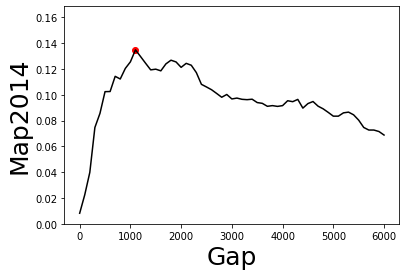

In [7]:
# Example of gap validation plot in the case of Logistic Regression. 
#The results have been computed on Advanced Research Computing (ARC) Oxford.

results = [0.008177623958331388, 0.02243271273385662, 0.03985823255784483, 0.07462663760904134, 0.08555264235649461, 0.1023942305845061, 0.10248915440958997, 0.11426226284277871, 0.11219539167189072, 0.12039128177097773, 0.12548226070304289, 0.13478172531462912, 0.1296016968599532, 0.12437262953302108, 0.11926890166986955, 0.11981250193077955, 0.11851113879207209, 0.1238968823610174, 0.12676886578466914, 0.1254085380289413, 0.12121599776446243, 0.12432247534064049, 0.12285720111495162, 0.11715573147446248, 0.10806563935807098, 0.1060219798779499, 0.10387556229275778, 0.10100849173874238, 0.09805367968049723, 0.10019773762664752, 0.09673437605551027, 0.09740793798341134, 0.09645901431769643, 0.09617688736558785, 0.09653709394380716, 0.09393654872728255, 0.09333964217219301, 0.09104201018138121, 0.09156679314769074, 0.09097370795413565, 0.09155777318407499, 0.09535074467428266, 0.09462436921776059, 0.09638769813743626, 0.08964212207607072, 0.09316101732485468, 0.09473588076557764, 0.0911345080016457, 0.08907265233154261, 0.08632755429232693, 0.08340386759555199, 0.08340386759555199, 0.08596463090631529, 0.08652832209878948, 0.08444130679143518, 0.08031759545122899, 0.0746399397735733, 0.07264419916685047, 0.07264419916685047, 0.07149838826095027, 0.06877111553367755]
gaps = list(range(0, 6100, 100))
best_index = 11
best_gap = 1100


fig = plt.figure()
axes = plt.gca()
axes.set_ylim([0, results[best_index] * 1.25])

plt.plot(best_gap, results[best_index], 'ro')

plt.plot(gaps, results, 'k')
plt.xlabel('Gap', fontsize = 25)
plt.ylabel('Map2014', fontsize = 25)
plt.show()